# Project Title - Prediction of drug side effects by observing similar   sub-classes in the molecular structure of drugs



Kshitij Prit Gopali     PES1UG19CS234       Section D  
Mrudhulraj Natarajan    PES1UG19CS281       Section E  
Navya Eedula            PES1UG19CS293       Section E  
Sarthak Deva            PES1UG19CS433       Section G  

__Requirements before running the Notebook__
1. A few models in the notebook require that it is run using GPU runtime.
2. The datasets, drug_SMILES_750.csv and data1.txt must be loaded into the /content folder

__Libraries__
1. networkx :  bipartite, degree_centrality, closeness_centrality, betweenness_centrality, projected_graph
2. matplotlib
3. nxviz : CircosPlot
4. torch
5. torch_geometric : RandomLinkSplit, GCNConv, negative_sampling, 
6. sklearn : StandardScaler, roc_auc_score, 
7. torchdrug : datasets, core, models, tasks

__Installations with versions__
1. nxviz : nxviz-0.7.4-py3-none-any.whl
2. cuda version installed : 1.11.0+cu113
3. torch-scatter : 1.4.0 
4. torch-sparse
5. pubchempy : PubChemPy-1.0.4.
6. torchdrug : torchdrug-0.1.2.post1-py3-none-any.whl

In [ ]:
import pandas as pd
import glob
import os
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import pprint

# EDA on drug-drug side effect dataset

In this EDA we visualize the drugs and side effects as a bipartite graph and evaluate the centrality measures to draw relevant conclusions.


In [ ]:
# Dataset
df = pd.read_csv("data1.txt", sep='\t')
df = df[['GenericName', 'SideeffectTerm']]

vis_df = df[:100]

print("Number of drugs in dataset:",len(set(df['GenericName'])))
print("Number of unique side effects:", len(set(df['SideeffectTerm'])))

Number of drugs in dataset: 759
Number of unique side effects: 994


In [ ]:
# Checking for NULL values in the dataset
print(df['GenericName'].isnull().values.any())
print(df['SideeffectTerm'].isnull().values.any())

False
False


## Bipartite Graph

We have identified and visualized the drug-drug side effect graph as a bipartite graph. This is because there are no edges between the drugs and side effects amongst themsleves but they interact with each other.


In [ ]:
# Creating a bipartite graph

G = nx.Graph()

# Add nodes with the node attribute "bipartite"
G.add_nodes_from(df['GenericName'], bipartite='drug')
G.add_nodes_from(df['SideeffectTerm'], bipartite='side_effect')

# Add edges only between nodes of opposite node sets
G.add_edges_from([tuple(x) for x in df.to_numpy()])

# Checking if the graph is Bipartite
bipartite.is_bipartite(G)

True

#Visualisation of the Bipartite Graph using NetworkX

Since the visualizaton of the entire dataset is results in a very messy graph, we have subsetted 100 rows of the dataset solely for visualization purpose. 

In [ ]:
# Creating a bipartite graph

vis_G = nx.Graph()

# Add nodes with the node attribute "bipartite"
vis_G.add_nodes_from(vis_df['GenericName'], bipartite='drug')
vis_G.add_nodes_from(vis_df['SideeffectTerm'], bipartite='side_effect')

# Add edges only between nodes of opposite node sets
vis_G.add_edges_from([tuple(x) for x in vis_df.to_numpy()])

# Checking if the graph is Bipartite
bipartite.is_bipartite(vis_G)

True

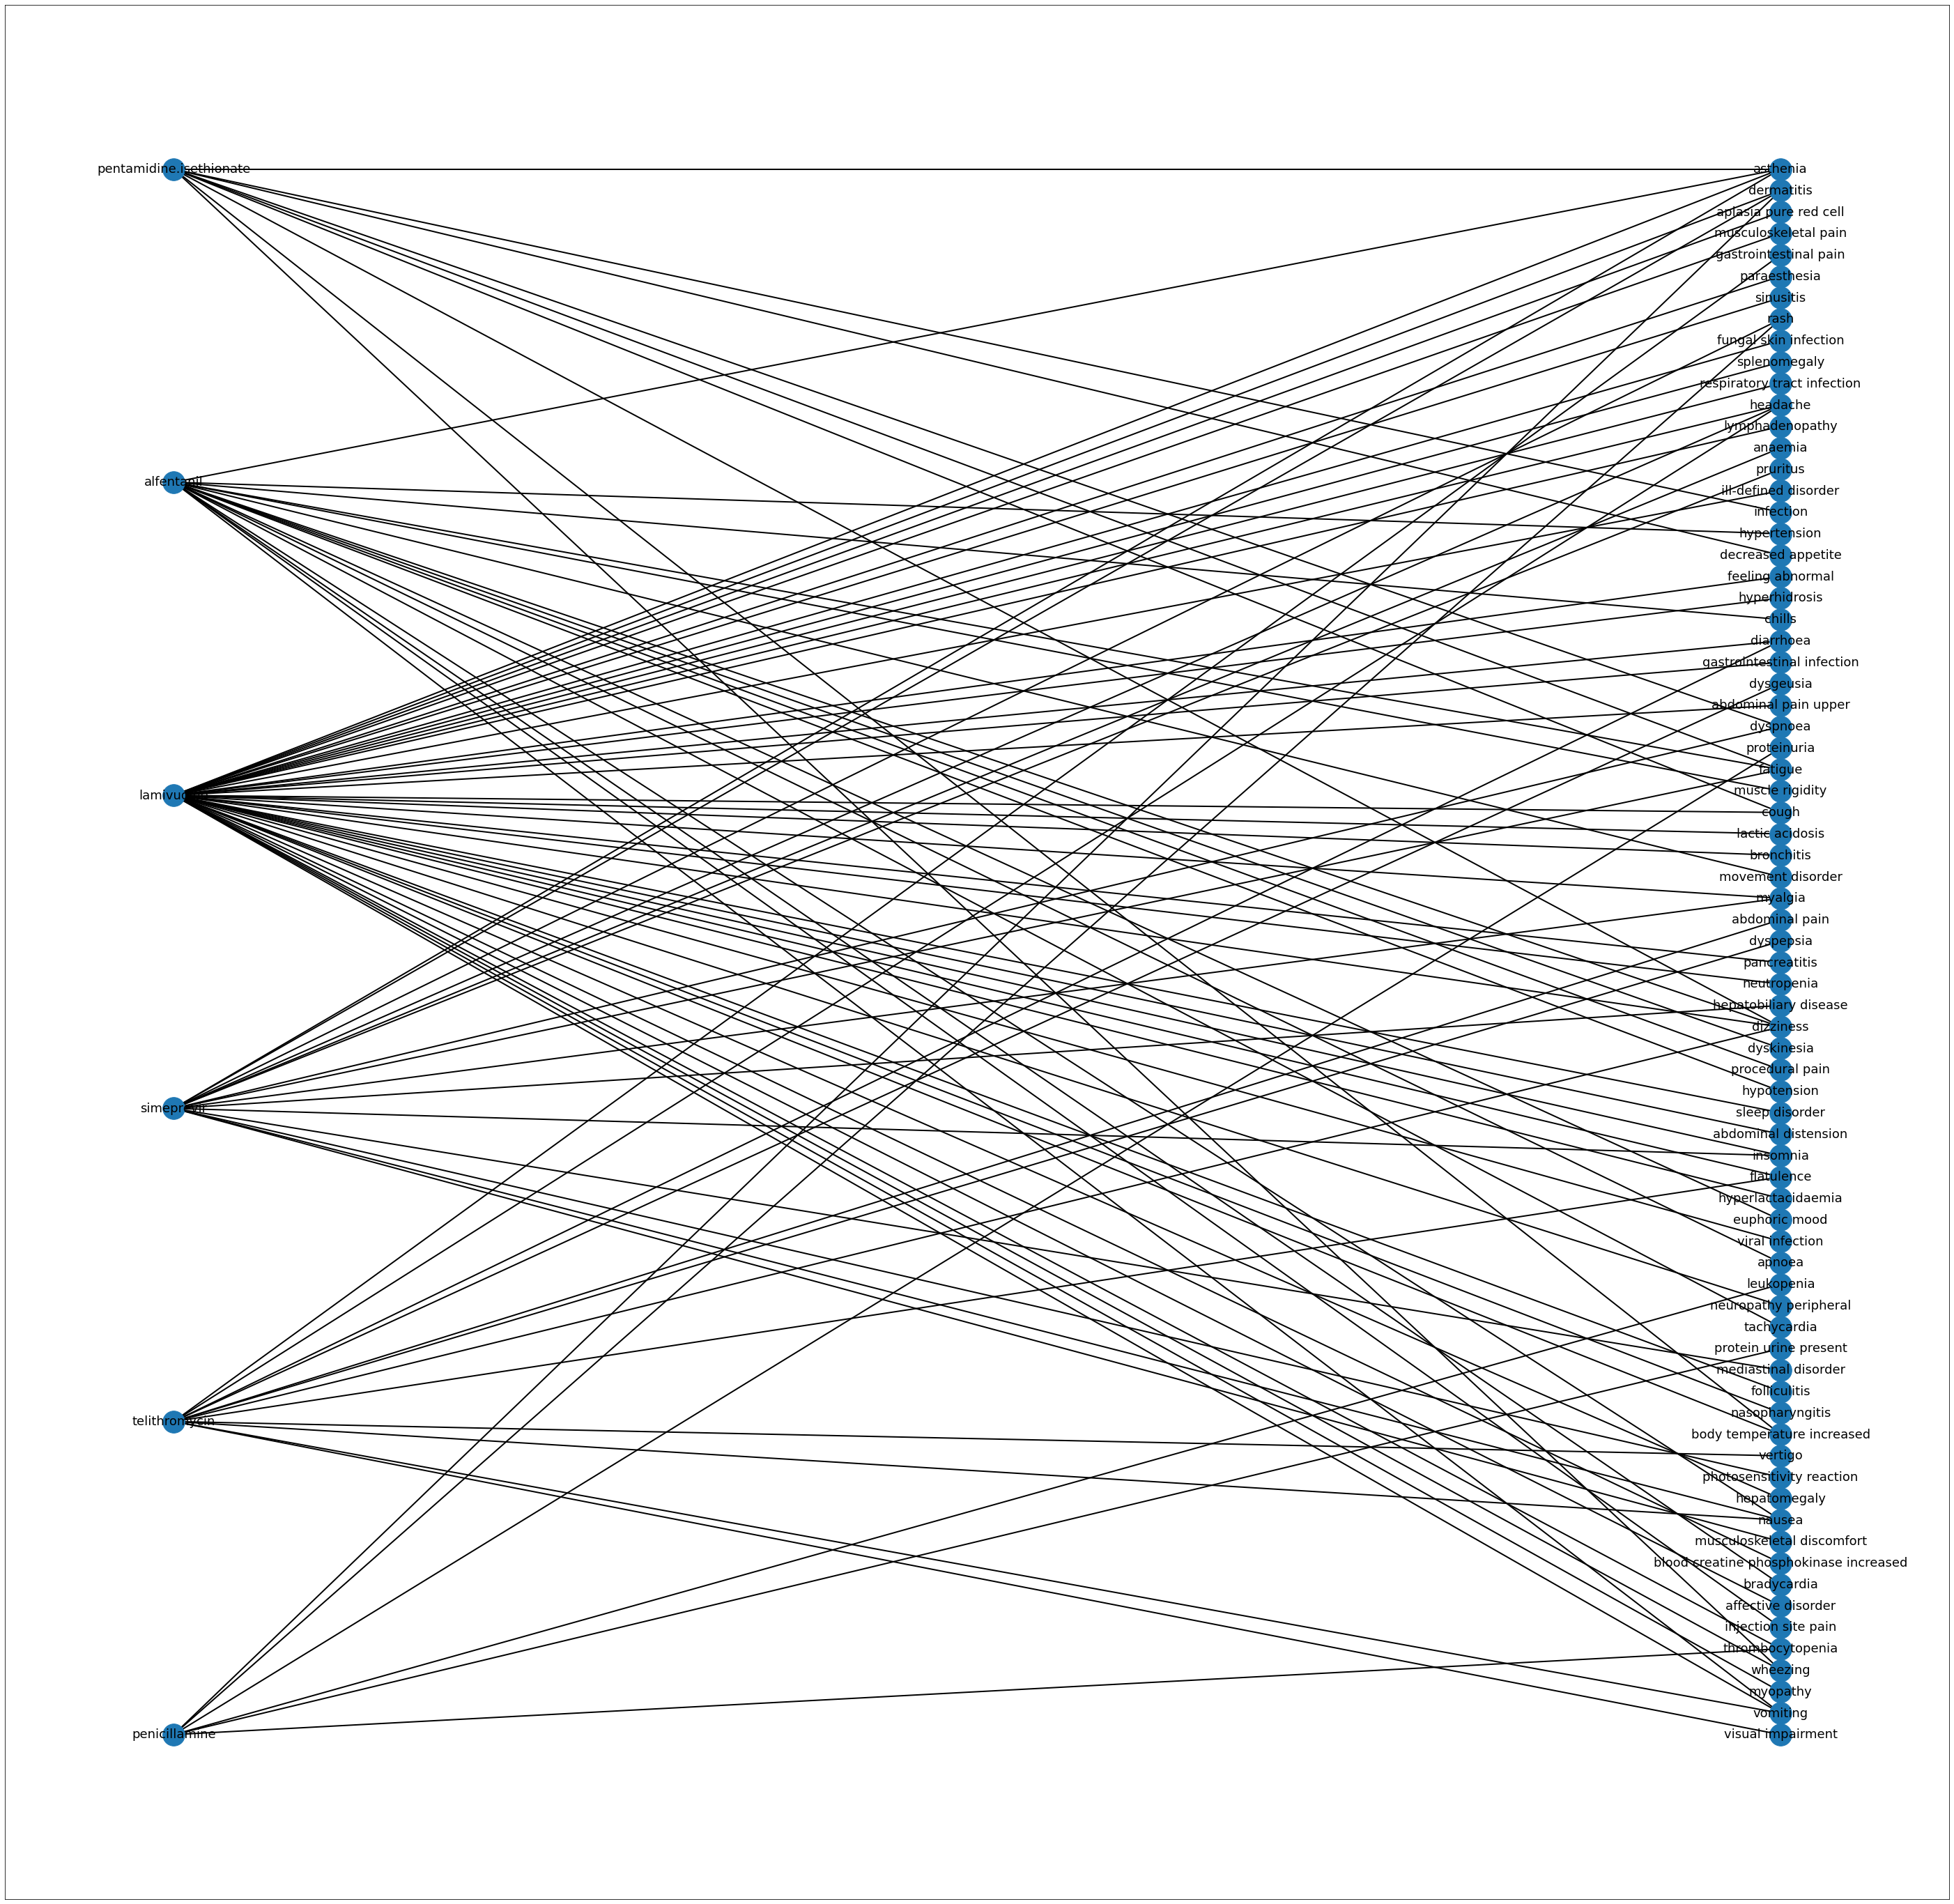

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(50,50))
pos = nx.draw_networkx(vis_G, pos = nx.drawing.layout.bipartite_layout(vis_G, vis_df['GenericName']), width = 2, node_size = 1000, edge_cmap=plt.cm.Blues, font_size = 18)
#nx.draw_networkx_edges(G, pos=pos)
#edge_labels = nx.get_edge_attributes(G, 'Weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
plt.show()


The measurement of degree centrality in Bipartite graph is the measure of dependency of a given node in a given set w.r.t set of of other set nodes in the bipartite graph. It is good to note that the degreee centrailty is measured for all nodes. This in conclusion conveys the fact that the higher the degree centrality for a drug the higher number of side-affects are observed. On the contary, higher the degree of a side effect the more common the side effect is observed in diverse number of drugs.

In [ ]:
# Finding degree centrality of the drug nodes:
from networkx.algorithms.bipartite.centrality import degree_centrality, closeness_centrality, betweenness_centrality

drug_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 'drug']
drug_nodes_with_centrality = [node for node in degree_centrality(G,drug_nodes).items() if node[0] in drug_nodes]

sorted(drug_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:10]


[('pregabalin', 0.5392354124748492),
 ('paroxetine', 0.4104627766599598),
 ('venlafaxine', 0.4024144869215292),
 ('ropinirole', 0.39839034205231394),
 ('escitalopram', 0.3853118712273642),
 ('gabapentin', 0.36519114688128773),
 ('rivastigmine', 0.34808853118712274),
 ('risperidone', 0.3279678068410463),
 ('fluoxetine', 0.30885311871227367),
 ('olanzapine', 0.306841046277666)]

In [ ]:
# Finding degree centrality of the side effect nodes:
side_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 'side_effect']

side_nodes_with_centrality = [node for node in nx.bipartite.degree_centrality(G, side_nodes).items() if node[0] in side_nodes]
sorted(side_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:10]

[('nausea', 0.7351778656126483),
 ('headache', 0.6798418972332017),
 ('dizziness', 0.6455862977602108),
 ('diarrhoea', 0.6231884057971014),
 ('vomiting', 0.5994729907773386),
 ('asthenia', 0.5678524374176548),
 ('dermatitis', 0.5349143610013175),
 ('rash', 0.5217391304347826),
 ('abdominal pain', 0.46113306982872204),
 ('gastrointestinal pain', 0.4519104084321476)]

Here, closeness centrality is measured for all nodes w.r.t a given node. The weights associated with the edges is :
2 For nodes belonging to the same set of the given node and
1 For nodes belonging to the other set of the given node.

In [ ]:
from networkx.algorithms.bipartite.centrality import closeness_centrality

drug_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 'drug']
drug_nodes_with_centrality = [node for node in closeness_centrality(G,drug_nodes).items() if node[0] in drug_nodes]
sorted(drug_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:10]

[('pregabalin', 0.7326328079392878),
 ('paroxetine', 0.6816947311243889),
 ('venlafaxine', 0.678011885467315),
 ('ropinirole', 0.6769147788565264),
 ('escitalopram', 0.6722013926084628),
 ('gabapentin', 0.6654294803817603),
 ('rivastigmine', 0.6594850236468733),
 ('risperidone', 0.6526261050442018),
 ('fluoxetine', 0.6459083890890376),
 ('olanzapine', 0.6449126413155191)]

In [ ]:
side_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 'side_effect']
side_nodes_with_centrality = [node for node in nx.bipartite.closeness_centrality(G, side_nodes).items() if node[0] in side_nodes]
sorted(side_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:10]

[('nausea', 0.8717053032708797),
 ('headache', 0.8495821727019499),
 ('dizziness', 0.836125494974109),
 ('diarrhoea', 0.8275550195960205),
 ('vomiting', 0.8181818181818182),
 ('asthenia', 0.8061674008810573),
 ('dermatitis', 0.7954216169226311),
 ('rash', 0.790838375108038),
 ('abdominal pain', 0.7699859747545582),
 ('gastrointestinal pain', 0.7665456576375315)]

In [ ]:
drug_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 'drug']
drug_nodes_with_centrality = [node for node in betweenness_centrality(G,drug_nodes).items() if node[0] in drug_nodes]
sorted(drug_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:10]

[('pregabalin', 0.056902048091845875),
 ('escitalopram', 0.035498108896649484),
 ('ropinirole', 0.028176971536929052),
 ('venlafaxine', 0.0270930717421129),
 ('paroxetine', 0.02643278221857011),
 ('gabapentin', 0.02080950071730759),
 ('nilotinib', 0.01771426052051978),
 ('tacrolimus', 0.01728600447818548),
 ('rivastigmine', 0.016944858837445304),
 ('ribavirin', 0.01664554105601629)]

In [ ]:
side_nodes = [node for node in G.nodes() if G.nodes[node]['bipartite'] == 'side_effect']
side_nodes_with_centrality = [node for node in betweenness_centrality(G, side_nodes).items() if node[0] in side_nodes]
sorted(side_nodes_with_centrality, key=lambda x: x[1], reverse=True)[:10]

[('nausea', 0.04431038405448098),
 ('headache', 0.04177079605522403),
 ('dizziness', 0.032592424595830435),
 ('diarrhoea', 0.029741647293445143),
 ('vomiting', 0.027178278783777834),
 ('asthenia', 0.022522586692079388),
 ('dermatitis', 0.022266345408981127),
 ('rash', 0.020369966112674585),
 ('pruritus', 0.01852061979349849),
 ('abdominal pain', 0.014926706884612626)]

It can been seen from above the degree centrality, closeness centrality and betweeneness centrality are in correspondence with each other. 

Hence, it can be concluded that pregabalin and paroxetine are drugs that produce the most number of side effects and nausea and headache are common side effects of most drugs. 

# Projection in Bipartite Graph

A projection of the bipartite graph can be made one of the node-set of the graph; either the drug nodes or the side effect nodes.



In [ ]:
!pip install nxviz

     |████████████████████████████████| 11.2 MB 7.9 MB/s 
     |████████████████████████████████| 930 kB 49.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In the first case, let us project the the bipartite graph onto the drug nodes. This means that an edge will be created between two drug nodes that give the same side effect. 


In [ ]:
drug_graph = nx.bipartite.projection.projected_graph(G, drug_nodes)
print([sorted((u, v)) for u, v in drug_graph.edges()][:100])

[['alfentanil', 'rabeprazole'], ['alfentanil', 'ibutilide'], ['alfentanil', 'metformin'], ['alfentanil', 'amoxicillin'], ['alfentanil', 'sitaxentan'], ['alfentanil', 'salmeterol'], ['alfentanil', 'clopidogrel'], ['alfentanil', 'insulin.detemir'], ['alfentanil', 'pegvisomant'], ['alfentanil', 'torasemide'], ['alfentanil', 'imipramine'], ['alfentanil', 'triptorelin'], ['alfentanil', 'armodafinil'], ['alfentanil', 'hyoscyamine'], ['alfentanil', 'indapamide'], ['alfentanil', 'pamidronic.acid'], ['alfentanil', 'bimatoprost'], ['alfentanil', 'pentostatin'], ['alfentanil', 'cabergoline'], ['alfentanil', 'eflornithine'], ['alfentanil', 'naproxen'], ['alfentanil', 'rivastigmine'], ['alfentanil', 'naltrexone'], ['alfentanil', 'eliglustat'], ['alfentanil', 'pomalidomide'], ['alfentanil', 'axitinib'], ['alfentanil', 'mesalazine'], ['alfentanil', 'cevimeline'], ['alfentanil', 'nifedipine'], ['alfentanil', 'florbetapir.(18F)'], ['alfentanil', 'bupivacaine'], ['alfentanil', 'riluzole'], ['alfentanil'

For the sake of visualization in a circos plot, we will use a subset of dataset. 

The circos plot can be used to easily visualize the relationship between the drug and side effect in the projected graph. 

In [ ]:
vis_drug_nodes = [node for node in vis_G.nodes() if vis_G.nodes[node]['bipartite'] == 'drug']
print("The drugs present in the subset include : ", vis_drug_nodes)
vis_drug_graph = nx.bipartite.projection.projected_graph(vis_G, vis_drug_nodes)

print(type(vis_drug_graph.nodes))

The drugs present in the subset include :  ['alfentanil', 'telithromycin', 'simeprevir', 'pentamidine.isethionate', 'penicillamine', 'lamivudine']
<class 'networkx.classes.reportviews.NodeView'>


The Circos plot is one of the most common plot for the visualization of genome data-sets in order to capture various data-types of chromosomes. In the given plot the Circos graph denotes the relationship between drugs that share common side-effects. This gives us an insight of the drugs that share similar properties. 

/usr/local/lib/python3.7/dist-packages/nxviz/__init__.py:29: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  """
/usr/local/lib/python3.7/dist-packages/nxviz/api.py:276: UserWarning: As of nxviz 0.7, the object-oriented API is being deprecated in favour of a functional API. Please consider switching your plotting code! The object-oriented API wrappers remains in place to help you transition over. A few changes between the old and new API exist; please consult the nxviz documentation for more information. When the 1.0 release of nxviz h

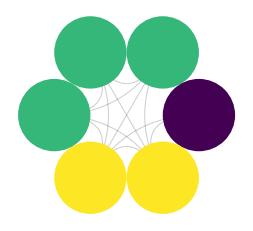

In [ ]:
from nxviz import CircosPlot
for n, d in vis_drug_graph.nodes(data=True):
    vis_drug_graph.nodes[n]['neighbors_count'] = len(list(vis_drug_graph.neighbors(n)))

c = CircosPlot(vis_drug_graph, node_color='neighbors_count', node_order='neighbors_count')
c

Here in this Circos Plot we have two side-effects that are caused by a common drug. The edges represent the common drug and nodes represent the side-effect. The higher the number of edges the higher the number of drugs that cause the same side-effect.

/usr/local/lib/python3.7/dist-packages/nxviz/api.py:276: UserWarning: As of nxviz 0.7, the object-oriented API is being deprecated in favour of a functional API. Please consider switching your plotting code! The object-oriented API wrappers remains in place to help you transition over. A few changes between the old and new API exist; please consult the nxviz documentation for more information. When the 1.0 release of nxviz happens, the object-oriented API will be dropped entirely.
  "As of nxviz 0.7, the object-oriented API is being deprecated "


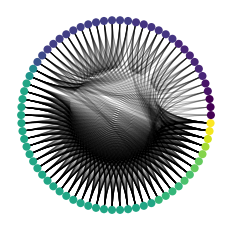

In [ ]:
from nxviz import CircosPlot

vis_side_nodes = [node for node in vis_G.nodes() if vis_G.nodes[node]['bipartite'] == 'side_effect']
vis_side_graph = nx.bipartite.projection.projected_graph(vis_G, vis_side_nodes)

for n, d in vis_side_graph.nodes(data=True):
    vis_side_graph.nodes[n]['neighbors_count'] = len(list(vis_side_graph.neighbors(n)))

c = CircosPlot(vis_side_graph, node_color='neighbors_count', node_order='neighbors_count')
c

# Prediction and node classification of drugs based on the subclasses  

The given dataset consists of drug names (common name) and the corresponding SMILES encoding. We have attempted to predict the side effects caused by certain sub-groups in the molecular structure of the drugs. 


In [ ]:
# Install required packages and configuring pytorch
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.11.0+cu113
     |████████████████████████████████| 7.9 MB 8.8 MB/s 
     |████████████████████████████████| 3.5 MB 21.5 MB/s 


In [ ]:
!pip install pubchempy

  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13834 sha256=dda1beb37efe75865ee6e2d0429d65110243155f43240f31765f86bedeaad84e
  Stored in directory: /root/.cache/pip/wheels/7c/3d/8c/8192697412e9899dc55bbbb08bbc1197bef333caaa2a71c448
Successfully built pubchempy


Pubchempy allows us the search the chemical formulas by name, substructure and similarity

## Utilizing the pubchempy library to convert drug names to IUPAC chemical names

In [ ]:
# Reading the data set with drug name and SMILES encoding
import pandas as pd
df=pd.read_csv("drug_SMILES_750.csv",header=None)
df2=pd.read_csv("data1.txt",sep='\t')

In [ ]:
from pubchempy import *
iupac=[]
c=0
for i in list(df[1]):
    c+=1
    #print(c)
    iupac.append(get_compounds(i,'smiles')[0].iupac_name)

## Converting drug from smiles to IUPAC name to determine the class of compunds based on the root or of the IUPAC nomenclature

In [ ]:
df['iupac']=iupac
df = df[df.iupac != None]

In [ ]:
# sub groups of drug molecules identified

clases=[]
ketone=0
dropl=[]
ll=list(df['iupac'])
for i in range(len(ll)):
  if ll[i]!=None:
    if ll[i].endswith('acid') :
      clases.append('acid')
    elif ll[i].endswith('one'):
      clases.append('ketone')
    elif ll[i].endswith('nitrate'):
      clases.append('nitrate')  
    elif ll[i].endswith('sulfate'):
      clases.append('sulfate')  
    elif ll[i].endswith('nitrile'):
      clases.append('nitrile')
    elif ll[i].endswith('tate'):
      clases.append('ester')
    elif ll[i].endswith('ol'):
      clases.append('alochol')
    elif ll[i].endswith('amide'):
      clases.append('amide')
    elif ll[i].endswith('oate'):
      clases.append('carboxylic acid')
    elif ll[i].endswith('amine'):
      clases.append('amine')
    elif ll[i].endswith('chloride'):
      clases.append('chloride')
    elif ll[i].endswith('carboxylate'):
      clases.append('carboxylate')
    elif ll[i].endswith('benzimidazole'):
      clases.append('benzimidazole')
    elif ll[i].endswith('azanium'):
      clases.append('azanium')
    else:
      clases.append('hydrocarbons')
  else:
    dropl.append(i)


In [ ]:
for i in dropl:
  df = df.drop([i])

df['category']=clases

df

0                                                  1  \
0          levocarnitine                            C[N+](C)(C)CC(CC(=O)O)O   
1    aminolevulinic.acid                                  C(CC(=O)O)C(=O)CN   
2       calcium.folinate  C1C(N(C2=C(N1)NC(=NC2=O)N)C=O)CNC3=CC=C(C=C3)C...   
3           epoprostenol           CCCCCC(C=CC1C(CC2C1CC(=CCCCC(=O)O)O2)O)O   
4              adenosine            C1=NC2=C(C(=N1)N)N=CN2C3C(C(C(O3)CO)O)O   
..                   ...                                                ...   
745              heparin  COC1C(C(C(OC1C(=O)[O-])OC2C(OC(C(C2[O-])NOS(=O...   
746        teriflunomide            CC(=C(C#N)C(=O)NC1=CC=C(C=C1)C(F)(F)F)O   
747          tigecycline  CC(C)(C)NCC(=O)NC1=C(C2=C(CC3CC4C(C(=O)C(=C(C4...   
748        colestyramine  CCC1=CC=C(C=C1)C(C)CCC2=CC=C(C=C2)[N+](C)(C)C....   
749   interferon.alfa-2b  CCCN(CCOC1=C(C=C(C=C1Cl)Cl)Cl)C(=O)N2C=CN=C2.C...   

                                                 iupac     category  
0         (3-carboxy-2-hydroxypropyl)-trimethylazanium      azanium  
1                          5-amino-4-oxopentanoic acid         acid  
2    2-[[4-[(2-amino-5-formyl-4-oxo-3,6,7,8-tetrahy...         acid  
3    5-[5-hydroxy-4-(3-hydroxyoct-1-enyl)-3,3a,4,5,...         acid  
4    2-(6-aminopurin-9-yl)-5-(hydroxymethyl)oxolane...      alochol  
..                                                 ...          ...  
745  4-hydroxy-3-methoxy-6-[6-methoxy-4-oxido-5-(su...  carboxylate  
746  2-cyano-3-hydroxy-N-[4-(trifluoromethyl)phenyl...        amide  
747  9-[[2-(tert-butylamino)acetyl]amino]-4,7-bis(d...        amide  
748  [4-[3-(4-ethylphenyl)butyl]phenyl]-trimethylaz...     chloride  
749  sodium;diiodomethanesulfonate;N-propyl-N-[2-(2...        amide  

[745 rows x 4 columns]

In [ ]:
def getclass(d):
  temp=str(df[df[0]==d]['category'])
  temp=temp.split('\n')[0]
  temp=temp.split()[1]
  return temp

dic={}
for i in df[0]:
  dic[i]=getclass(i)

len(dic)
# print(dic)

745

In [ ]:
cat=[]
dropc=[]
df2l=list(df2['GenericName'])
for i in range(len(df2l)):
  if df2l[i] in dic:
    temp=dic[df2l[i]]
    #print('temp',temp)
    cat.append(temp)
  else:
    dropc.append(i)
len(cat)
for i in dropc:
  df2 = df2.drop([i])

# print(cat)

df2['category']=cat

In [ ]:
df2

GenericName              SideeffectTerm  FrequencyRatingValue  \
0       alfentanil                    asthenia                     4   
1       alfentanil           movement disorder                     4   
2       alfentanil                  dyskinesia                     4   
3       alfentanil                 tachycardia                     5   
4       alfentanil                hypertension                     5   
...            ...                         ...                   ...   
37436  ciclosporin             fluid retention                     4   
37437  ciclosporin  musculoskeletal discomfort                     4   
37438  ciclosporin               gynaecomastia                     3   
37439  ciclosporin                   hirsutism                     5   
37440  ciclosporin           visual impairment                     2   

       Unnamed: 3 category  
0             NaN    amide  
1             NaN    amide  
2             NaN    amide  
3             NaN    amide  
4             NaN    amide  
...           ...      ...  
37436         NaN   ketone  
37437         NaN   ketone  
37438         NaN   ketone  
37439         NaN   ketone  
37440         NaN   ketone  

[36952 rows x 5 columns]

In [ ]:
df2.to_csv('drug_side_class')

In [ ]:
import torch as th

# tag=dict(zip(df.))
print(len(list(df2.SideeffectTerm)))
print(len(list(set(list(df2.SideeffectTerm)))))

36952
994


In [ ]:
unique_sideeff=list(set(list(df2.SideeffectTerm)))
unique_class=list(set(list(df2.category)))

In [ ]:
tag = dict(zip(df2.SideeffectTerm, df2.category))

In [ ]:
mapdf=pd.DataFrame()
viewd=pd.DataFrame()

In [ ]:
mapdf['source']=list(df2['category'])[:100]
mapdf['target']=list(df2['SideeffectTerm'])[:100]
viewd['source']=list(df2['category'])
viewd['target']=list(df2['SideeffectTerm'])
mapdf

source                      target
0    amide                    asthenia
1    amide           movement disorder
2    amide                  dyskinesia
3    amide                 tachycardia
4    amide                hypertension
..     ...                         ...
95  ketone       neuropathy peripheral
96  ketone  body temperature increased
97  ketone                   dizziness
98  ketone            thrombocytopenia
99  ketone                    myopathy

[100 rows x 2 columns]

## Visualization of the molecular sub-class and side effects graph

In [ ]:
import networkx as nx
from torch_geometric.utils.convert import from_networkx
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
G=nx.Graph()
mainG=nx.Graph()
for _, edge in mapdf.iterrows():
    G.add_edge(edge['source'], edge['target'])
for _, edge in viewd.iterrows():
    mainG.add_edge(edge['source'], edge['target'])

Here, the nodes with the darker colours in this graph are the subclasses as they are connected to a large number of side effects. 

It seems as though there molecular groups most responsible for most side effects include acids, hydrocarbons, ketones and amides.


Visualising a smaller subset of this dataset

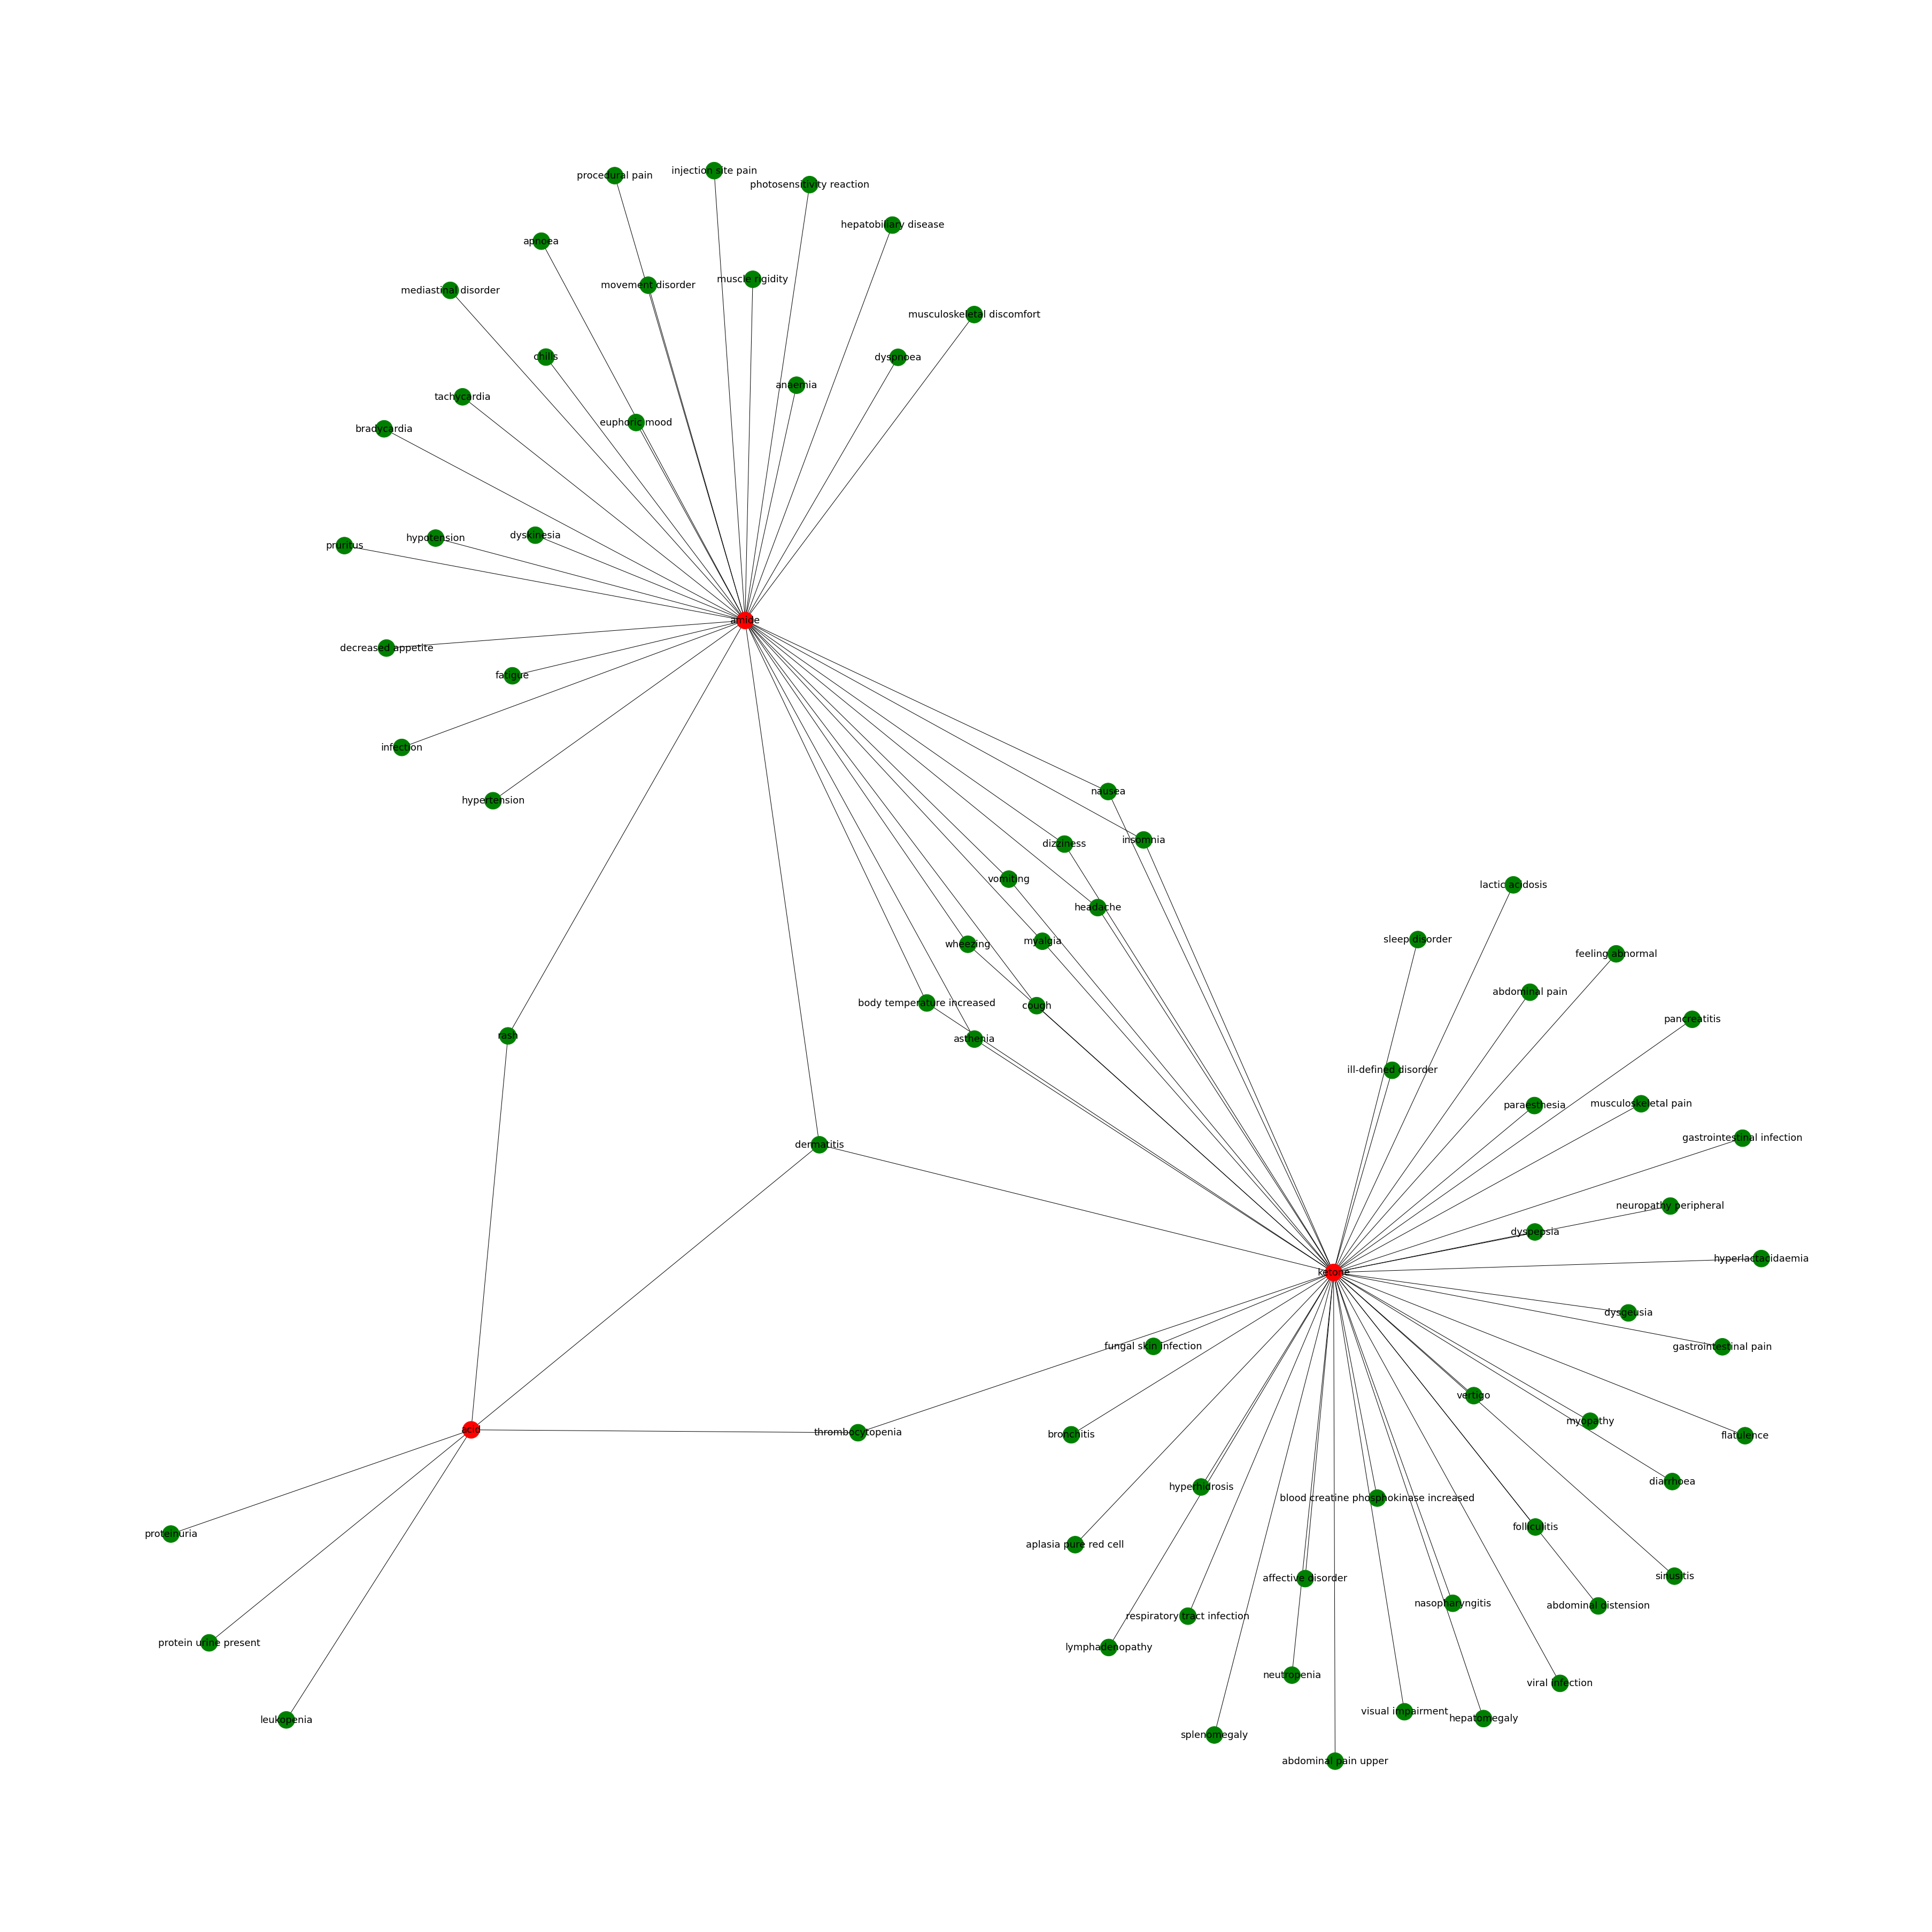

In [ ]:
%matplotlib inline
plt.figure(figsize=(50,50))
color_map = ['red' if node in unique_class else 'green' for node in G]   
nx.draw(G, node_color=color_map, node_size=1000, pos=pos, with_labels=True, font_size = 18)
plt.savefig('sf_clas.png')

A better visualization would be in the form of a bipartite graph. This will provide a clear distinction between the molecular sub-groups and the side effects of the molecular sub groups.

Here the red nodes represent the sub-class and the green nodes represent the side effects caused by drugs containing these molecular subgroups.

In [ ]:
# Creating a bipartite graph

from networkx.algorithms import bipartite

B = nx.Graph()

# Add nodes with the node attribute "bipartite"
B.add_nodes_from(mapdf['source'], bipartite='subclass')
B.add_nodes_from(mapdf['target'], bipartite='side_effect')

# Add edges only between nodes of opposite node sets
B.add_edges_from([tuple(x) for x in mapdf.to_numpy()])

# Checking if the graph is Bipartite
bipartite.is_bipartite(B)

True

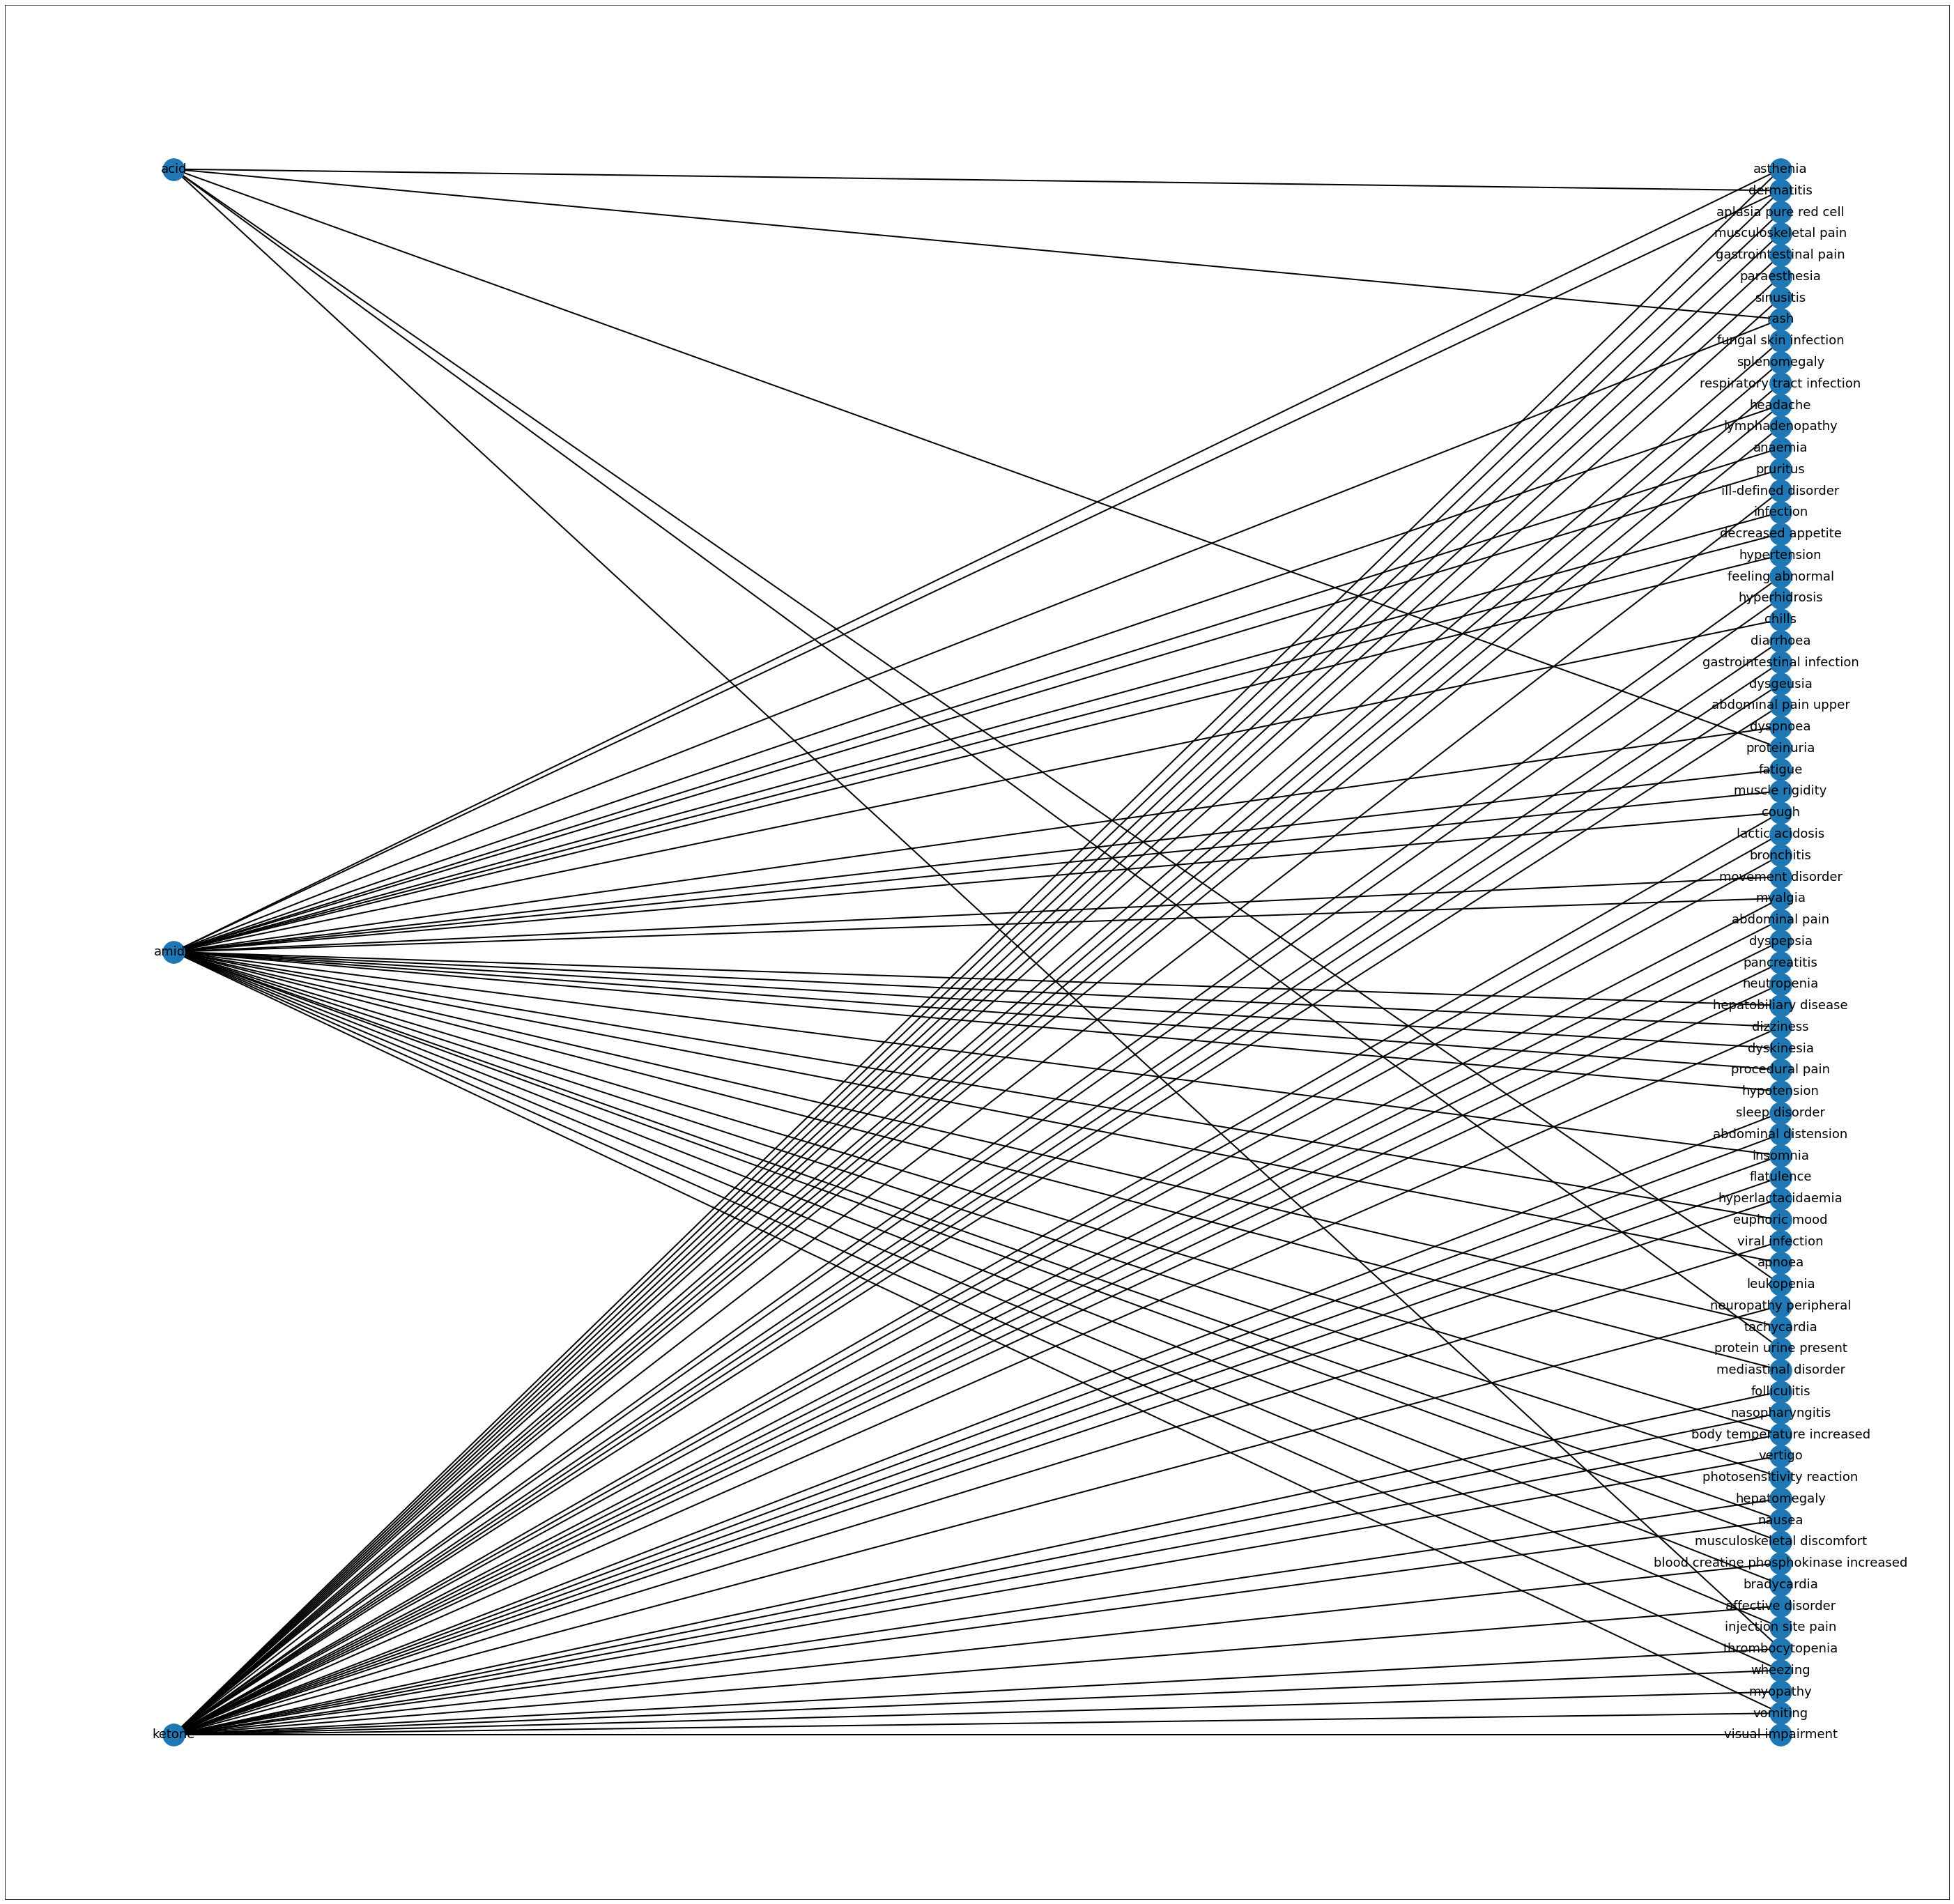

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(50,50))
pos = nx.draw_networkx(B, pos = nx.drawing.layout.bipartite_layout(B, mapdf['source']), width = 2, node_size = 1000, edge_cmap=plt.cm.Blues, font_size = 18)
#nx.draw_networkx_edges(G, pos=pos)
#edge_labels = nx.get_edge_attributes(G, 'Weight')
#nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
plt.show()


In [ ]:
pyg = from_networkx(mainG)
print(pyg)

Data(edge_index=[2, 14520], num_nodes=1009)


In [ ]:
embeddings = np.array(list(dict(mainG.degree()).values()))
embeddings

array([823,  15,   4, ...,   4, 150,   2])

In [ ]:
# normalizing degree  using StandardScaler
from sklearn.preprocessing import StandardScaler
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit


scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))
pyg.x = torch.from_numpy(embeddings).type(torch.float32)
pyg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


In [ ]:
# Splitting edges into train, validate and test data
# each element representing the corresponding split.
dataset = pyg
dataset = dataset.to(device)
transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(dataset)

print(dataset.num_features)

1


In [ ]:
from torch_geometric.nn.conv import GCNConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)

# hold the current state and will update the parameters based on the computed gradients.
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# combining loss with sigmoid layer
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training the model

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # Negative sampling - gives random negative edges given the edge index ; 
    #the weights of few edges that are randomly selected are updated at a time
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# Testing the model
from sklearn.metrics import roc_auc_score
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
from torch_geometric.utils import negative_sampling
best_val_auc = final_test_auc = 0
for epoch in range(1, 6):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test - The best Area under the Curve: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6319, Val: 0.9973, Test: 0.9946
Epoch: 002, Loss: 0.6052, Val: 0.9972, Test: 0.9945
Epoch: 003, Loss: 0.6076, Val: 0.9971, Test: 0.9945
Epoch: 004, Loss: 0.5974, Val: 0.9968, Test: 0.9943
Epoch: 005, Loss: 0.5912, Val: 0.9967, Test: 0.9943
Final Test - The best Area under the Curve: 0.9943


# Molecular classifier based on torchdrug

Torch drug consists of popular data sets for drug discovery and graph representation learning.

The dataset used in this model is the ClinTox dataset. 
Our task in this particular section to predict whether a molecule is toxic or not.

In [ ]:
!pip install torchdrug

     |████████████████████████████████| 191 kB 26.5 MB/s 
     |████████████████████████████████| 22.7 MB 1.2 MB/s 
     |████████████████████████████████| 108 kB 57.9 MB/s 


In [ ]:
import torch
from torch.nn import functional as F
from torchdrug import datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]

# The default split performed by this function is 8:1:1
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

18:41:24   Downloading http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv.gz
18:41:24   Extracting /root/molecule-datasets/clintox.csv.gz to /root/molecule-datasets/clintox.csv


Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   5%|▌         | 75/1484 [00:00<00:01, 744.07it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Ca`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:  10%|█         | 150/1484 [00:00<00:02, 543.80it/s]/usr/local/lib/python3.7/dist-package

# Graph Neural Network

GNN model is used for encoding of molecular graphs.

In [ ]:
from torchdrug import core, models, tasks

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],  # 4 hidden layers
                   short_cut=True, batch_norm=True, concat_hidden=True)

In [ ]:
# Classification task that is defined by the BCE criterion

task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

In [ ]:
# Model training and creating Adam Optimizer for the parameters

optimizer = torch.optim.Adam(task.parameters(), lr=1e-4)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer,
                     batch_size=1024, gpus=[0])
solver.train(num_epoch=100)

18:41:39   Preprocess training set
18:41:49   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:41:49   Epoch 0 begin
18:42:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:42:07   binary cross entropy: 6.73785
18:42:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:42:07   Epoch 0 end
18:42:07   duration: 28.37 secs
18:42:07   speed: 0.07 batch / sec
18:42:07   ETA: 46.80 mins
18:42:07   max GPU memory: 720.6 MiB
18:42:07   ------------------------------
18:42:07   average binary cross entropy: 5.5811
18:42:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:42:07   Epoch 1 begin
18:42:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:42:07   Epoch 1 end
18:42:07   duration: 0.34 secs
18:42:07   speed: 5.95 batch / sec
18:42:07   ETA: 23.44 mins
18:42:07   max GPU memory: 719.9 MiB
18:42:07   ------------------------------
18:42:07   average binary cross entropy: 2.18732
18:42:07   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:42:07   Epoch 2 begin
18:42:08   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:42:08   Epoch 2 end
18:42:08   duration: 0.39 secs
18:42:08   sp

In [ ]:
# Testing the model

solver.evaluate("valid")

18:44:57   Evaluate on valid
18:44:57   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
18:44:57   auprc [CT_TOX]: 0.295092
18:44:57   auprc [FDA_APPROVED]: 0.949054
18:44:57   auroc [CT_TOX]: 0.69489
18:44:57   auroc [FDA_APPROVED]: 0.702093


{'auprc [CT_TOX]': tensor(0.2951, device='cuda:0'),
 'auprc [FDA_APPROVED]': tensor(0.9491, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.6949, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.7021, device='cuda:0')}

Observe that predicted toxicty by the model is 69% which nearly equal to the actual toxicty of the molecule being 70% .